# Import Libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'


# Import Databases

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
#Display all database


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(train.describe())

DRIVERS       PASSPORT            LAT            LON  \
count  117626.000000  117626.000000  117626.000000  117626.000000   
mean        0.984893       0.981798      42.277680     -71.359367   
std         0.121980       0.133681       0.280508       0.596881   
min         0.000000       0.000000      41.241591     -73.490615   
25%         1.000000       1.000000      42.127735     -71.547931   
50%         1.000000       1.000000      42.317179     -71.154738   
75%         1.000000       1.000000      42.456124     -71.024347   
max         1.000000       1.000000      42.901078     -69.921561   

       HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE            Age  \
count         1.176260e+05         1.176260e+05  117626.000000   
mean          1.024948e+06         3.479806e+04      55.459924   
std           5.462052e+05         8.344889e+04      18.752622   
min           5.166400e+02         0.000000e+00       0.000000   
25%           6.113264e+05         5.121200e+03      41.000000   
50%           1.170679e+06         9.262400e+03      59.000000   
75%           1.468529e+06         1.823913e+04      71.000000   
max           3.203008e+06         1.557373e+06      84.000000   

       Allergy to bee venom  Allergy to dairy product  Allergy to eggs  \
count          10872.000000              10872.000000     10872.000000   
mean               0.172553                  0.038263         0.049301   
std                0.377878                  0.191840         0.216506   
min                0.000000                  0.000000         0.000000   
25%                0.000000                  0.000000         0.000000   
50%                0.000000                  0.000000         0.000000   
75%                0.000000                  0.000000         0.000000   
max                1.000000                  1.000000         1.000000   

       Allergy to fish  Allergy to grass pollen  Allergy to mould  \
count     10872.000000             10872.000000      10872.000000   
mean          0.167770                 0.254875          0.364330   
std           0.373679                 0.435811          0.481264   
min           0.000000                 0.000000          0.000000   
25%           0.000000                 0.000000          0.000000   
50%           0.000000                 0.000000          0.000000   
75%           0.000000                 1.000000          1.000000   
max           1.000000                 1.000000          1.000000   

       Allergy to nut  Allergy to peanuts  Allergy to soya  \
count    10872.000000        10872.000000     10872.000000   
mean         0.169794            0.188466         0.016924   
std          0.375469            0.391102         0.128993   
min          0.000000            0.000000         0.000000   
25%          0.000000            0.000000         0.000000   
50%          0.000000            0.000000         0.000000   
75%          0.000000            0.000000         0.000000   
max          1.000000            1.000000         1.000000   

       Allergy to tree pollen  Allergy to wheat  Dander (animal) allergy  \
count            10872.000000      10872.000000             10872.000000   
mean                 0.252024          0.045438                 0.334989   
std                  0.434195          0.208272                 0.472008   
min                  0.000000          0.000000                 0.000000   
25%                  0.000000          0.000000                 0.000000   
50%                  0.000000          0.000000                 0.000000   
75%                  1.000000          0.000000                 1.000000   
max                  1.000000          1.000000                 1.000000   

       House dust mite allergy  Latex allergy  Shellfish allergy  \
count             10872.000000   10872.000000       10872.000000   
mean                  0.249264       0.068893           0.327539   
std                   0.432607       0.253283           0.4

In [5]:
#save oof
oof_df = train[["Id", "COVID_Status"]]

# Hyperparameters

In [6]:
seed = 42
#Using the parameters from ICU mortality 

param = {'num_leaves': 15, 
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'colsample_bytree': 0.6189140385454879,
        'subsample': 0.7098267979279573,
        'reg_alpha': 5, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1,
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'binary',  
        'verbose': 1,
        'metric': {'binary_logloss', 'auc'},
        'is_unbalance': False, 
        'boost_from_average': True,
        'extra_trees': True
    }

In [7]:
train.drop(columns=['Death', 'Hospitalized', 'Ventilator', 'ICU', 
                    'Id', 'Days_hospitalized', 'Days_ICU'], inplace=True)  

In [8]:
test.drop(columns=['Id'], inplace=True)

In [9]:
predictors_int = list(train.columns)

In [10]:
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY',  'PLACE_BIRTH']

In [11]:
predictors_int.remove('DRIVERS')
predictors_int.remove('PASSPORT')
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')

# Creation of Dummies and missing values handling

In [12]:
train['is_train'] = 1
test['is_train'] = 0
train_test= pd.concat([train,test], axis = 0, sort=False)

In [13]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [14]:
train = train_test.loc[train_test.is_train==1]

In [15]:
train = train.drop(columns=['is_train'])

In [16]:
test = train_test.loc[train_test.is_train==0]
#test.drop(columns=['is_train'], inplace=True)

In [17]:
test = test.drop(columns=['is_train'])

In [18]:
predictors = list(train.columns)
predictors.remove('COVID_Status')

In [19]:
#predictors.remove('Oxygen saturation in Arterial blood')
#predictors.remove('Body temperature')
#predictors.remove('Respiratory rate')
#predictors.remove('Heart rate')

# Training Loop

In [20]:
from sklearn.model_selection import KFold
nfold = 5
target = 'COVID_Status'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [21]:

i = 1

for train_index, valid_index in skf.split(train, train.COVID_Status.values):
    print("\nfold {}".format(i))
    
    #Train data
    t=train.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train.iloc[valid_index][predictors].values,
                           label=train.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 50000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100)  #1000
    oof[valid_index] = clf.predict(train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    predictions += clf.predict(test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.290386	training's auc: 0.894157	valid_1's binary_logloss: 0.290084	valid_1's auc: 0.883331

fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.301155	training's auc: 0.886935	valid_1's binary_logloss: 0.298442	valid_1's auc: 0.883202

fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.342713	training's auc: 0.883136	valid_1's binary_logloss: 0.339303	valid_1's auc: 0.881603

fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.642406	training's auc: 0.879341	valid_1's binary_logloss: 0.643543	valid_1's auc: 0.876518

fold 5
Training until validation scores don't improve for 100 rounds.
Ear

In [22]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train.COVID_Status.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train.COVID_Status.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train.COVID_Status.values.astype(bool), oof) -1))



CV AUC: 0.87242


CV log loss: 0.37709


CV Gini: 0.74484


In [23]:
print(metrics.classification_report(train.COVID_Status.values.astype(bool), oof >0.5))

              precision    recall  f1-score   support

       False       1.00      0.58      0.74     43929
        True       0.80      1.00      0.89     73697

    accuracy                           0.84    117626
   macro avg       0.90      0.79      0.81    117626
weighted avg       0.87      0.84      0.83    117626



In [24]:
print(metrics.classification_report(train.COVID_Status.values.astype(bool), oof >0.3))

              precision    recall  f1-score   support

       False       1.00      0.58      0.74     43929
        True       0.80      1.00      0.89     73697

    accuracy                           0.84    117626
   macro avg       0.90      0.79      0.81    117626
weighted avg       0.87      0.84      0.83    117626



In [25]:
print(metrics.classification_report(train.COVID_Status.values.astype(bool), oof >0.2))

              precision    recall  f1-score   support

       False       1.00      0.58      0.73     43929
        True       0.80      1.00      0.89     73697

    accuracy                           0.84    117626
   macro avg       0.90      0.79      0.81    117626
weighted avg       0.87      0.84      0.83    117626



# Export results

In [26]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["COVID_Status"] = predictions

In [27]:
sub_df[['Id', 'COVID_Status']].to_csv("lightgbm_Covid_status.csv", index=False, line_terminator='\n', header=False)

In [28]:
np.mean(predictions)

0.6271041450844284

In [29]:
oof_df.loc[:,"prediction_LGBM"] = oof
oof_df[:10]

,Id,COVID_Status,prediction_LGBM
0,93fa6213-73a1-4cce-b408-9986a4145801,0,0.139529
1,53bbfa41-5cab-422e-a8a7-8fa3ae55ed71,0,0.821273
2,30fb496e-b8d3-4d36-8e50-86acb3d1a223,0,0.835584
3,afa2680f-7f73-46d9-b0cd-2cf3db49724b,1,0.634381
4,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,1,0.878287
5,90031c21-e8a4-416e-b60b-23e871ee62dc,1,0.820922
6,0ac2e031-ab88-41f9-ac5d-d7d588952222,1,0.827851
7,45138fb4-dc79-4aec-ba78-7a012d3edca7,1,0.824661
8,fba0823a-d6fc-402f-a6c3-9394f54b1870,1,0.838268
9,93ef4d47-2a1e-4af1-b792-96a6077b75e0,1,0.821046


In [30]:
oof_df.to_csv("Ooflightgbm.csv", index=False)

# Explainability

In [31]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [32]:
fpr_rf, tpr_rf, _ = roc_curve(train.COVID_Status.values.astype(bool), oof)

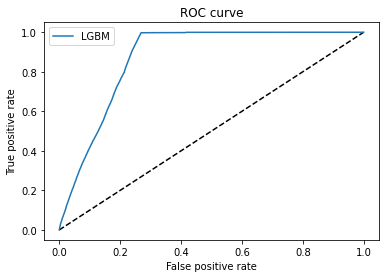

In [33]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [34]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(train.COVID_Status.values.astype(bool), oof)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.88


In [35]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [36]:
#https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#simple-xgboost-classifier

In [37]:
import seaborn as sns

In [38]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [39]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

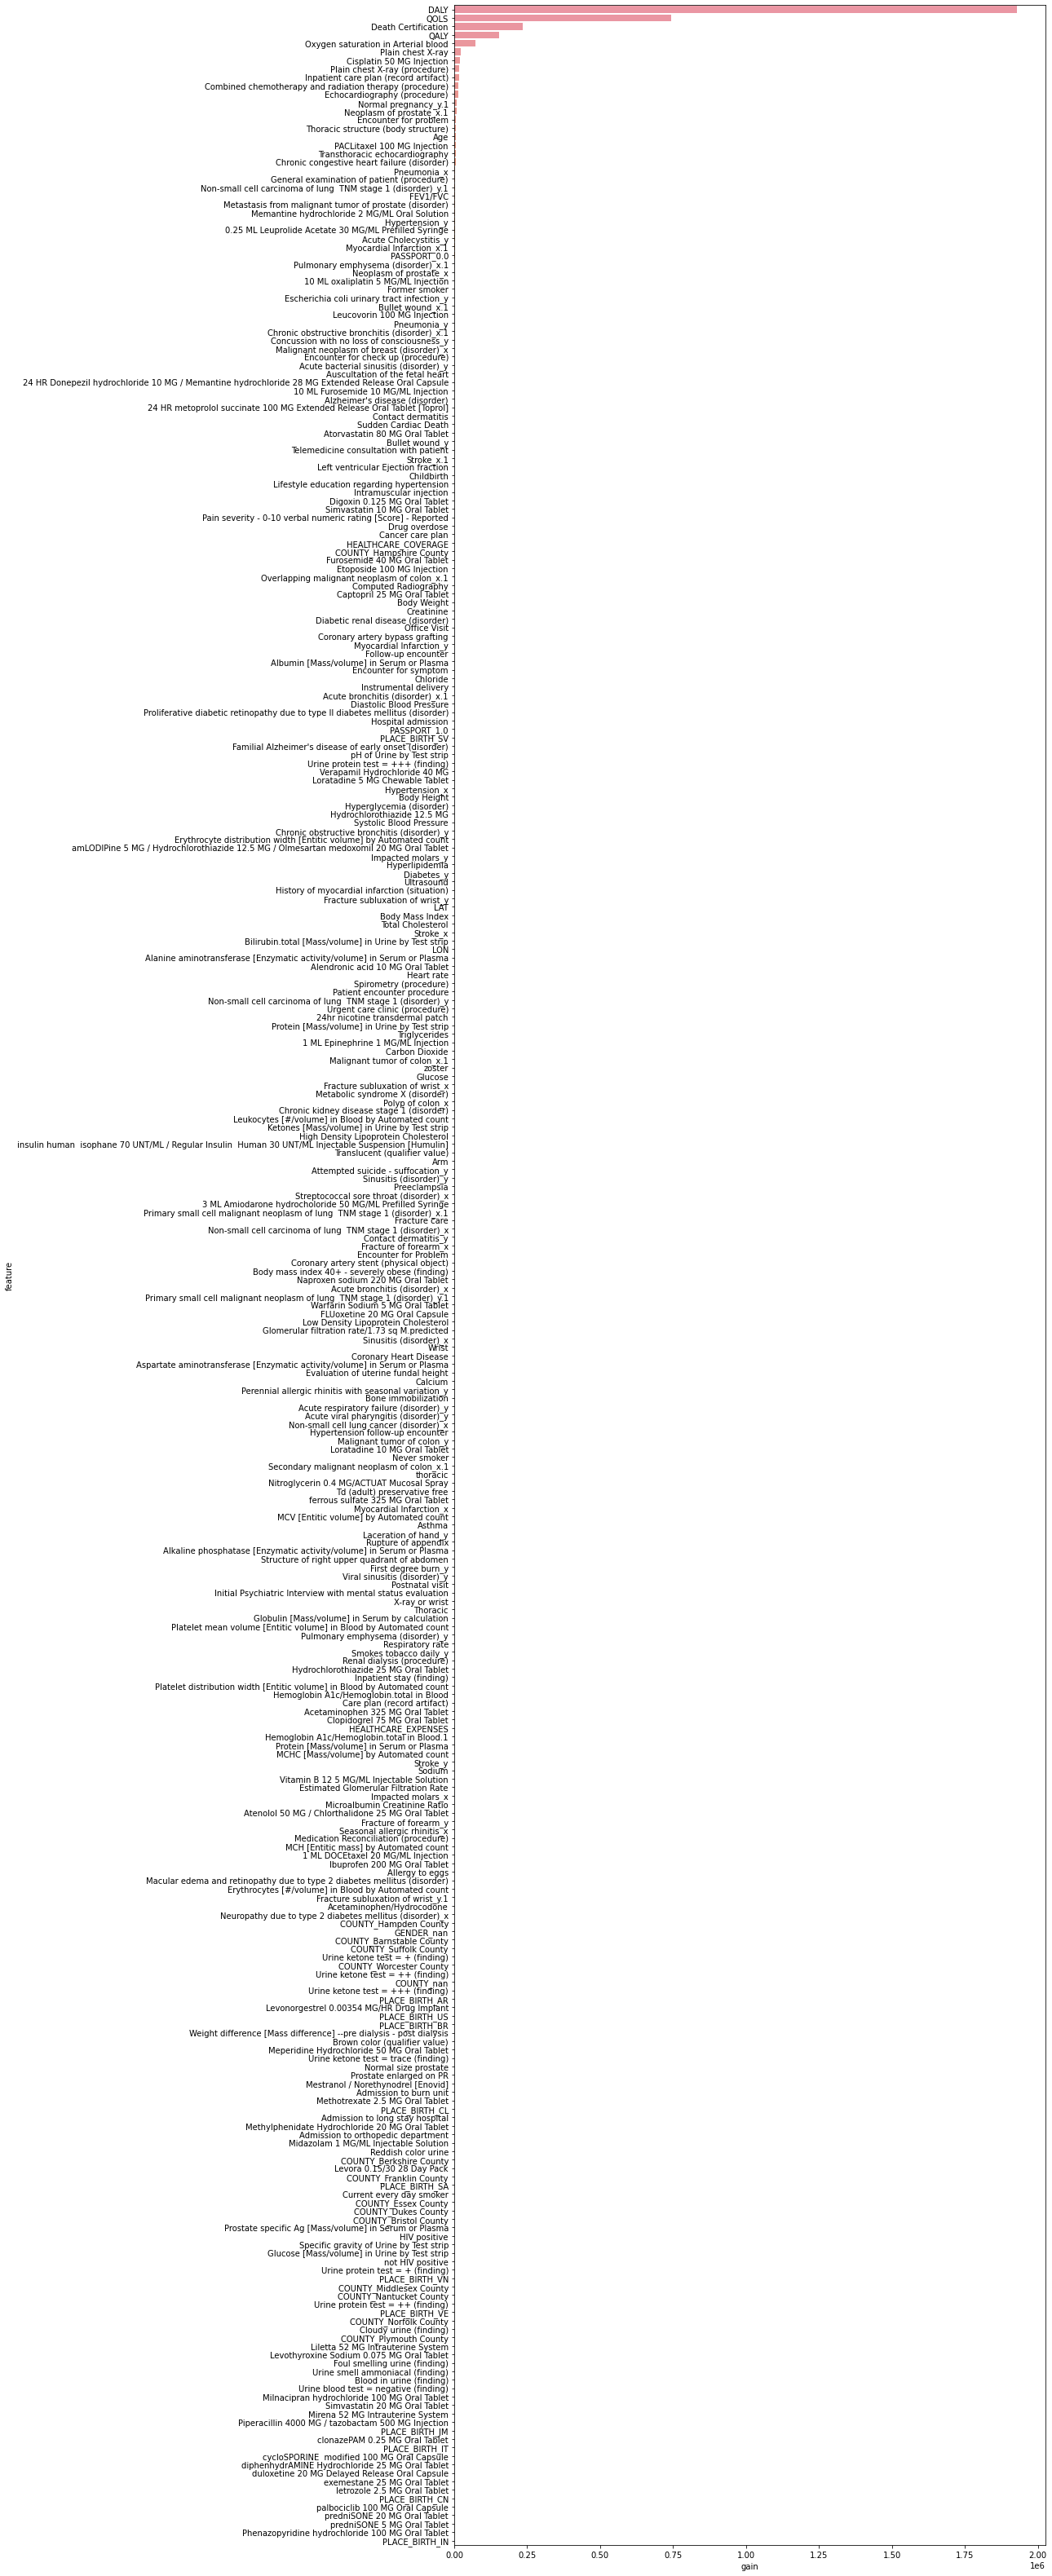

In [40]:
plot_importances(imp_df)

In [41]:
import shap

explainer   =  shap.TreeExplainer(clf)
shap_values = explainer.shap_values(t[predictors].iloc[:8000,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#train = train_test[train_test['is_train']==1]
column =
column in ['Admission to surgical departmentis_missing',
                          'Admission to thoracic surgery departmentis_missing']


invalid value encountered in greater
invalid value encountered in less


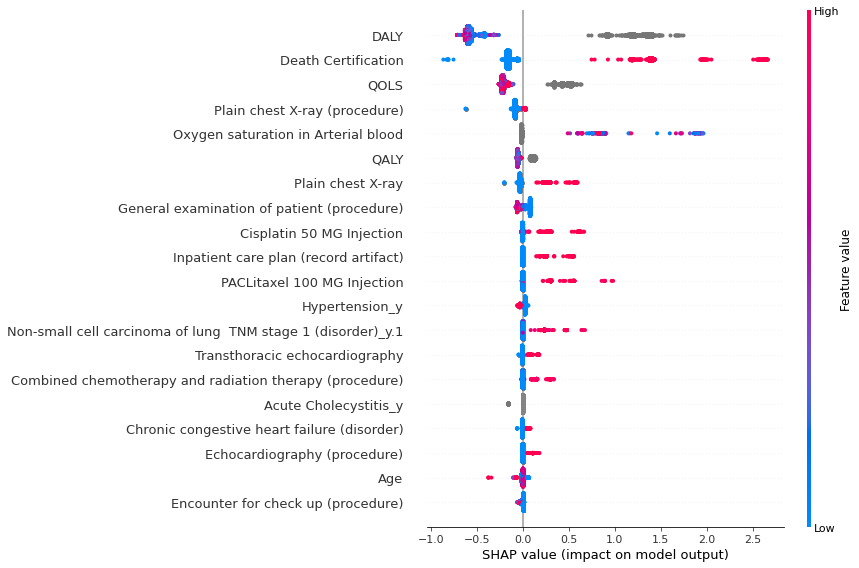

In [42]:
shap.summary_plot(shap_values[0], t[predictors].iloc[:8000,:])

In [43]:
#!pip install -U matplotlib

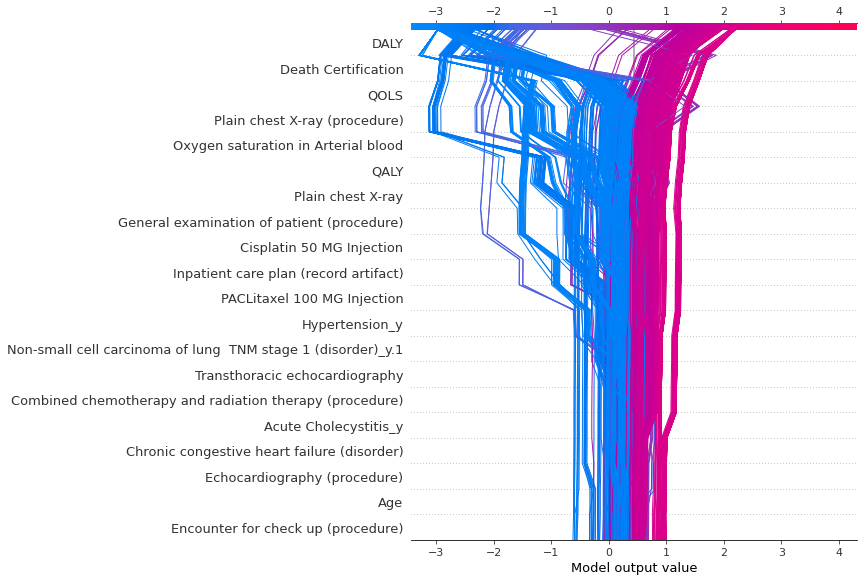

In [44]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], predictors, ignore_warnings=True,
                  legend_labels=None)

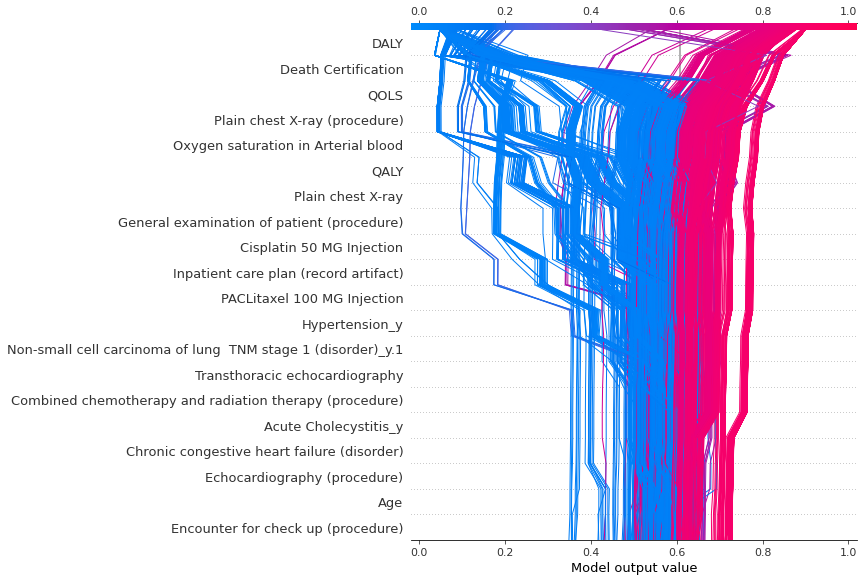

In [45]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], predictors, ignore_warnings=True, 
                   link='logit') 

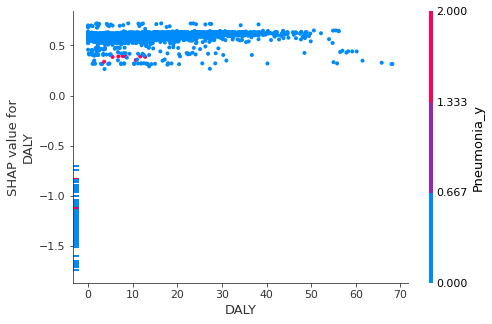

In [46]:
shap.dependence_plot('DALY', shap_values[1], t[predictors].iloc[:8000,:])

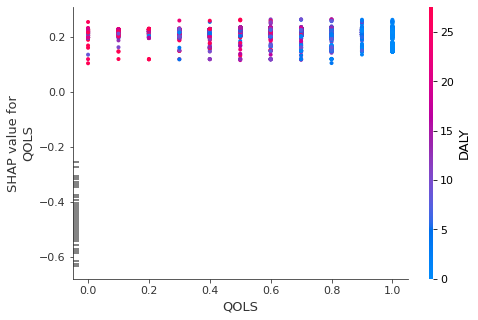

In [47]:
shap.dependence_plot('QOLS', shap_values[1], t[predictors].iloc[:8000,:], interaction_index='DALY')

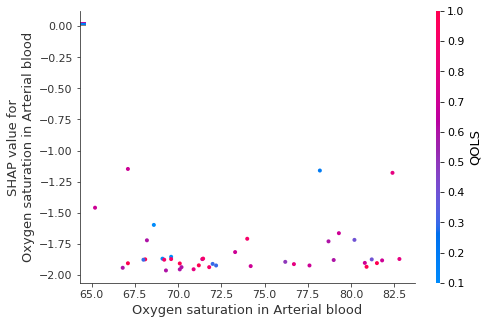

In [48]:
shap.dependence_plot('Oxygen saturation in Arterial blood', shap_values[1], t[predictors].iloc[:8000,:])

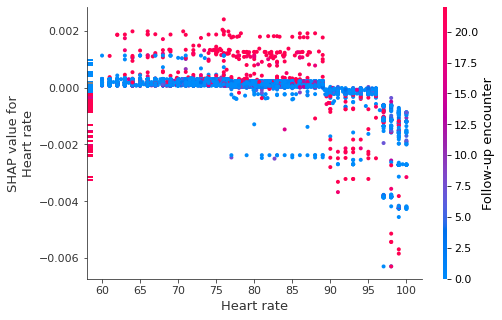

In [49]:
shap.dependence_plot('Heart rate', shap_values[1], t[predictors].iloc[:8000,:])

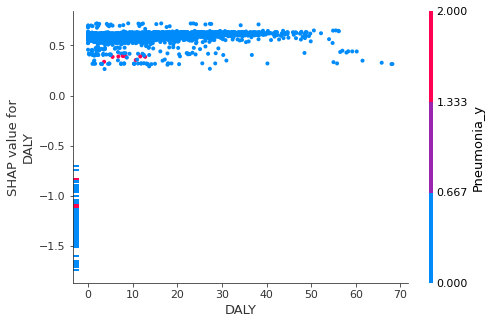

In [50]:
shap.dependence_plot('DALY', shap_values[1], t[predictors].iloc[:8000,:])

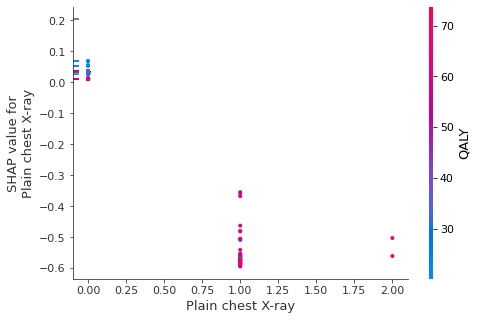

In [51]:
shap.dependence_plot('Plain chest X-ray', shap_values[1], t[predictors].iloc[:8000,:])

In [52]:
shap.initjs()
# visualize the training set predictions
# SHAP plots for all the data is very slow, so we'll only do it for a sample. Taking the head instead of a random sample is dangerous! 
i = 3

shap.force_plot(explainer.expected_value[1], shap_values[0][i,:], t[predictors].iloc[i,:])

In [53]:
#for test

shap_values = explainer.shap_values(test[predictors].iloc[:,:])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [54]:
shap.initjs()
# visualize the training set predictions
# SHAP plots for all the data is very slow, so we'll only do it for a sample. Taking the head instead of a random sample is dangerous! 
i = 1

shap.force_plot(explainer.expected_value[1], shap_values[0][i,:], test[predictors].iloc[i,:])